In [140]:
# parser = argparse.ArgumentParser(description="Choose RNN module: LSTM or GRU")
# parser.add_argument("--rnn_module", type=str, default="LSTM", help="Choose RNN module: LSTM or GRU")
# args = parser.parse_args()

rnn = "GRU"


In [141]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

import matplotlib.pyplot as plt


import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

from tqdm import trange, tqdm

# Import the single DOF finite difference model MLP model
from mlp_quadruped_rnn import MLP, MLPQuadrupedProjectionFilter, CustomGRULayer, GRU_Hidden_State, CustomLSTMLayer, LSTM_Hidden_State

from scipy.spatial.transform import Rotation as R
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

/home/alinjar/simple_training_warm_start/Quadruped_qp
Using cuda device


In [142]:
def sample_uniform_variables(key, var_min, var_max, dataset_size, nvar):
    rng = np.random.default_rng(seed=key)
    xi_samples = rng.uniform(
        low=var_min,
        high=var_max,
        size=(dataset_size, nvar)
    )
    return xi_samples, rng

In [143]:
# Parameters for Quadruped Model
num_batch = 1
timestep = 0.05  # 50 Hz control frequency
horizon = 10     # prediction horizon steps
num_legs = 4
friction_coeff = 0.2
body_mass = 50.0  # kg

body_inertia=(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

# Desired motion parameters
# desired_speed_x_tensor, rng = sample_uniform_variable(42, -0.5, 0.5, 1, 1)
# desired_speed_x = desired_speed_x_tensor.squeeze().item()
# print("desired_speed_x", desired_speed_x)
desired_body_height = 0.5     # m



In [144]:


# Problem dimensions for quadruped force control


##Parameters for MLP model
# Default states
BaseRollPitchYaw = (0.0, 0.0, 0.0)
AngularVelocityBodyFrame = (0.0, 0.0, 0.0)
ComVelocityBodyFrame = (0.0, 0.0, 0.0)
FootContacts = (True, True, True, True)
slope_estimate = (0.0, 0.0, 0.0)
RotationBodyWrtWorld = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

roll, pitch, yaw = BaseRollPitchYaw

# Create rotation object from Euler angles (in radians)
rot = R.from_euler('xyz', [roll, pitch, yaw])

# Convert to rotation matrix
rotation_matrix = rot.as_matrix()  # Shape (3, 3)

# Flatten into a 9-element tuple (row-major order)
RotationBodyWrtWorld = tuple(rotation_matrix.flatten())
#self.RotationBodyWrtWorld = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)



In [145]:
"""Setup foot positions and default states for quadruped"""
# Foot positions in body frame
foot_x=0.2
foot_y=0.2
foot_z=-desired_body_height

FootPositionsInBodyFrame = torch.tensor([
    [ foot_x,  foot_y, foot_z],
    [-foot_x,  foot_y, foot_z],
    [ foot_x, -foot_y, foot_z],
    [-foot_x, -foot_y, foot_z]])

In [146]:
# Maximum Iterations
maxiter_projection = 10

nvar = 3*num_legs*horizon

num_total_constraints = 2*nvar

In [147]:
desired_speed_batched, rng_desired_speed_batched = sample_uniform_variables(41, var_min= -0.2, var_max = 0.2, dataset_size=num_batch, nvar=2)
desired_twisting_speed_batched,  rng_desired_twisting_speed_batched = sample_uniform_variables(
                                                                      42, var_min= -0.2, var_max = 0.2, dataset_size=num_batch, 
                                                                      nvar=1)

desired_speed_batched_val, rng_desired_speed_batched = sample_uniform_variables(40, var_min= -0.1, var_max = 0.1, dataset_size=num_batch, nvar=2)
desired_twisting_speed_batched_val,  rng_desired_twisting_speed_batched = sample_uniform_variables(
                                                                      39, var_min= -0.1, var_max = 0.1, dataset_size=num_batch,
                                                                      nvar=1)

print("desired_speed_batched.shape", desired_speed_batched.shape)
print("desired_twisting_speed_batched.shape", desired_twisting_speed_batched.shape)


desired_speed_batched.shape (1, 2)
desired_twisting_speed_batched.shape (1, 1)


In [148]:
inp = np.hstack((desired_speed_batched, desired_twisting_speed_batched))


In [149]:
if rnn == "GRU":
    print("Inferencing with GRU")
    #GRU handling
    rnn = "GRU"
    gru_input_size = 3*num_total_constraints+3*nvar
    # print(gru_input_size)
    gru_hidden_size = 512
    # gru_output_size = (2*nvar)**2+2*nvar
    gru_output_size = num_total_constraints+nvar
    # gru_context_size = mlp_planner_inp_dim

    gru_context = CustomGRULayer(gru_input_size, gru_hidden_size, gru_output_size)

    rnn_context = gru_context


    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = gru_hidden_size

    gru_init  =  GRU_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)
    
    rnn_init = gru_init
    ##
elif rnn == "LSTM":
    print("Inferencing with LSTM")
    #LSTM handling
    rnn = "LSTM"
    lstm_input_size = 3*num_total_constraints+3*nvar
    # print(lstm_input_size)
    lstm_hidden_size = 512
    # lstm_output_size = (2*nvar)**2+2*nvar
    lstm_output_size = num_total_constraints+nvar
    # lstm_context_size = mlp_planner_inp_dim

    lstm_context = CustomLSTMLayer(lstm_input_size, lstm_hidden_size, lstm_output_size)

    rnn_context = lstm_context

    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = lstm_hidden_size

    lstm_init = LSTM_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)

    rnn_init = lstm_init

    ##

##


Inferencing with GRU


In [150]:

enc_inp_dim = np.shape(inp)[1] 
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 2*nvar + num_total_constraints #( xi_samples- 0:nvar, lamda_smples- nvar:2*nvar)

mlp =  MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)




In [151]:
# Create the quadruped model
model = MLPQuadrupedProjectionFilter(
    mlp=mlp,
    rnn_context=rnn_context, 
    rnn_init=rnn_init, 
    num_batch=num_batch,
    maxiter_projection=maxiter_projection,
    BaseRollPitchYaw=BaseRollPitchYaw,
    AngularVelocityBodyFrame=AngularVelocityBodyFrame,
    ComVelocityBodyFrame=ComVelocityBodyFrame,
    FootPositionsInBodyFrame=FootPositionsInBodyFrame,
    FootContacts=FootContacts,
    slope_estimate=slope_estimate,
    RotationBodyWrtWorld=RotationBodyWrtWorld, 
    desired_body_height=desired_body_height,
    body_mass=body_mass,
    body_inertia=body_inertia,
    num_legs=num_legs,
    friction_coeff=friction_coeff,
    timestep=timestep,
    horizon=horizon,
    rnn=rnn).to(device)

print(type(model))

model.load_state_dict(torch.load(f'./training_weights/mlp_learned_quadruped_{rnn}.pth', weights_only=True))
model.eval()

<class 'mlp_quadruped_rnn.MLPQuadrupedProjectionFilter'>


MLPQuadrupedProjectionFilter(
  (mlp): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=3, out_features=1024, bias=True)
      (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=1024, out_features=1024, bias=True)
      (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=1024, out_features=256, bias=True)
      (9): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (10): ReLU()
      (11): Dropout(p=0.2, inplace=False)
      (12): Linear(in_features=256, out_features=480, bias=True)
    )
  )
  (gru_context): CustomGRULayer(
    (gru_cell): GRUCell(1080, 512)
    (output_transform): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=360, bias=True)
    )
  )
  (gru_init): GRU_Hidden_Sta

In [152]:
######
#Generate Test Data




desired_speed_batched = np.array([[0.0, 0.0]])               # shape (1, 2)
desired_twisting_speed_batched = np.array([[0.0]])           # shape (1, 1)
desired_speed_test = torch.from_numpy(desired_speed_batched).float().to(device)
desired_twisting_speed_test = torch.from_numpy(desired_twisting_speed_batched).float().to(device)

inp = np.hstack((desired_speed_batched, desired_twisting_speed_batched))



inp_test = inp
inp_test = torch.tensor(inp_test).float()
inp_test = inp_test.to(device)
# inp_mean = inp_test.mean()
# inp_std = inp_test.std()

inp_test_median_ = torch.median(inp_test, dim=0).values
inp_test_q1 = torch.quantile(inp_test, 0.25, axis=0)
inp_test_q3 = torch.quantile(inp_test, 0.75, axis=0)
inp_test_iqr_ = inp_test_q3 - inp_test_q1
# Handle constant features
inp_test_iqr_ = torch.where(inp_test_iqr_ == 0, torch.tensor(1.0), inp_test_iqr_)
inp_norm_test = (inp_test - inp_test_median_) / inp_test_iqr_
# inp_test = torch.vstack([inp_test] * num_batch)
#inp_norm_test = (inp_test - inp_mean) / inp_std
inp_norm_test = inp_norm_test.to(device)


#desired_speed_batched, rng_desired_speed_batched = sample_uniform_variables(None, var_min= -2, var_max = 2, dataset_size=num_batch, nvar=2)




with torch.no_grad():
    (xi_projected, 
     avg_res_fixed_point, 
     avg_res_primal, 
     avg_res_qp_loss, 
     res_primal_history, 
     res_fixed_point_history, 
    qp_cost_history) = model.decoder_function(inp_norm_test, desired_speed_test, desired_twisting_speed_test, rnn)


In [153]:
# Convert to numpy for analysis

xi_filtered_np = np.array(xi_projected.cpu().detach().numpy())
prime_residuals_np = np.array(res_primal_history.cpu().detach().numpy())
fixed_residuals_np = np.array(res_fixed_point_history.cpu().detach().numpy())
qp_cost_residuals_np = np.array(qp_cost_history.cpu().detach().numpy())
# Print convergence statistics
print(f"\nConvergence Statistics:")
# print(f"Final primal residual - Mean: {np.mean(prime_residuals_np[-1]):.6f}, Max: {np.max(prime_residuals_np[-1]):.6f}")
# print(f"Final fixed point residual - Mean: {np.mean(fixed_residuals_np[-1]):.6f}, Max: {np.max(fixed_residuals_np[-1]):.6f}")

print(f"Prime residuals shape: {prime_residuals_np.shape}")
print(f"Fixed point residuals shape: {fixed_residuals_np.shape}")
print(f"QP Cost residuals shape: {qp_cost_residuals_np.shape}")

#Save
os.makedirs('results_quadruped_{rnn}_inference', exist_ok=True)

#Start
print("Start")
print(f"Max Prime residuals start: {max(prime_residuals_np[0])}")
print(f"Min Prime residuals start: {min(prime_residuals_np[0])}")
print(f"Max fixed residuals start: {max(fixed_residuals_np[0])}")
print(f"Min fixed residuals start: {min(fixed_residuals_np[0])}")
print(f"Max QP Cost residuals start: {max(qp_cost_residuals_np[0])}")
print(f"Min QP Cost residuals start: {min(qp_cost_residuals_np[0])}")

#End
print("End")
print(f"Max Prime residuals end: {max(prime_residuals_np[-1])}")
print(f"Min Prime residuals end: {min(prime_residuals_np[-1])}")
print(f"Max fixed residuals end: {max(fixed_residuals_np[-1])}")
print(f"Min fixed residuals end: {min(fixed_residuals_np[-1])}")
print(f"Max QP Cost residuals end: {max(qp_cost_residuals_np[-1])}")
print(f"Min QP Cost residuals end: {min(qp_cost_residuals_np[-1])}")



np.savetxt('results_quadruped_{rnn}_inference/projected_trajectory.csv', xi_filtered_np, delimiter=',')
np.savetxt('results_quadruped_{rnn}_inference/prime_residuals.csv', prime_residuals_np, delimiter=',')
np.savetxt('results_quadruped_{rnn}_inference/fixed_residuals.csv', fixed_residuals_np, delimiter=',')
np.savetxt('results_quadruped_{rnn}_inference/qp_cost_residuals.csv', qp_cost_residuals_np, delimiter=',')


Convergence Statistics:
Prime residuals shape: (10, 1)
Fixed point residuals shape: (10, 1)
QP Cost residuals shape: (10, 1)
Start
Max Prime residuals start: 0.0
Min Prime residuals start: 0.0
Max fixed residuals start: 5.047509670257568
Min fixed residuals start: 5.047509670257568
Max QP Cost residuals start: 83.87702941894531
Min QP Cost residuals start: 83.87702941894531
End
Max Prime residuals end: 0.0
Min Prime residuals end: 0.0
Max fixed residuals end: 7.83406925201416
Min fixed residuals end: 7.83406925201416
Max QP Cost residuals end: 266.10467529296875
Min QP Cost residuals end: 266.10467529296875


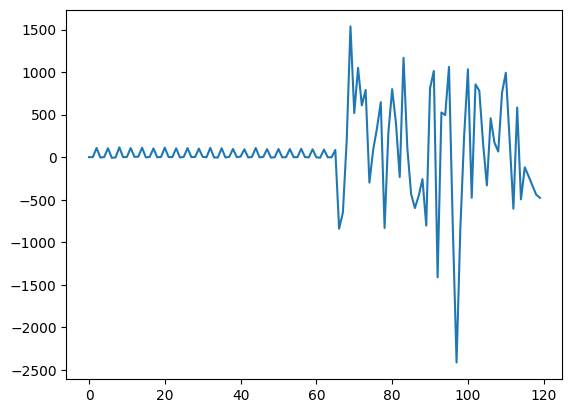

In [154]:

%matplotlib inline
plt.figure(3)
plt.plot(xi_filtered_np.T)
plt.show()

In [155]:
import numpy as np
import matplotlib.pyplot as plt


def visualize_residuals(residuals):
    """Visualize residuals across iterations for a specific batch sample"""
    
    # residuals shape: (maxiter_projection, num_batch)
    # Extract residuals for specific batch sample
    
    residuals_sample = residuals
    
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(residuals_sample, 'b-', marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Residual')
    plt.title(f'ADMM Residuals Convergence )')
    plt.grid(True)
    
    try:
        plt.show()
    except:
        plt.savefig(f"residuals_batch.png")
        print(f"Residuals plot saved as residuals_batch.png")
        


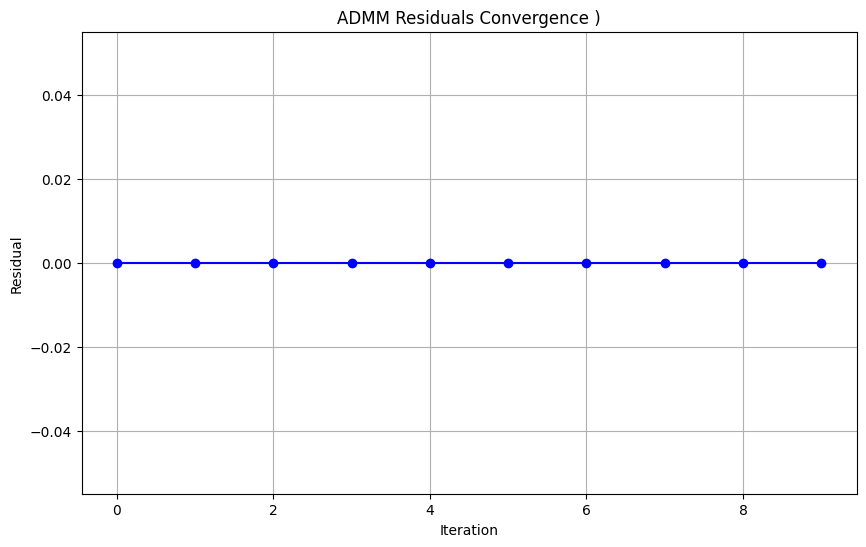

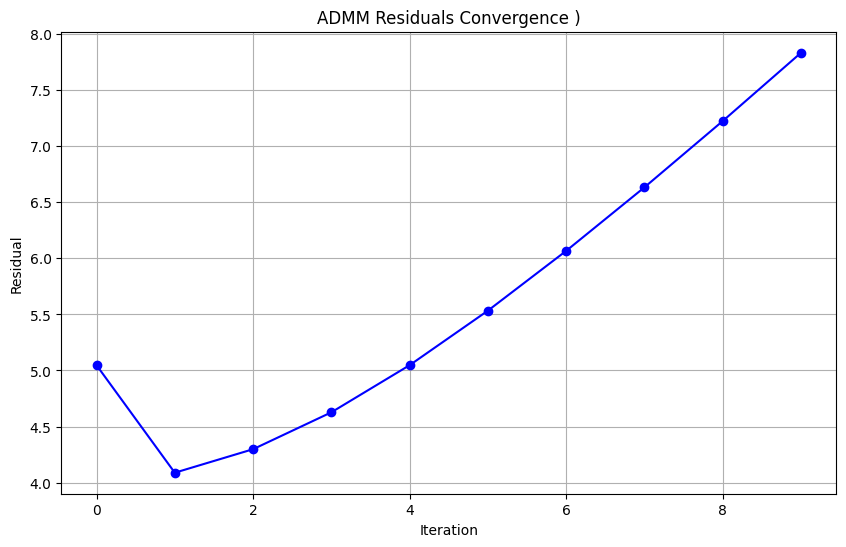

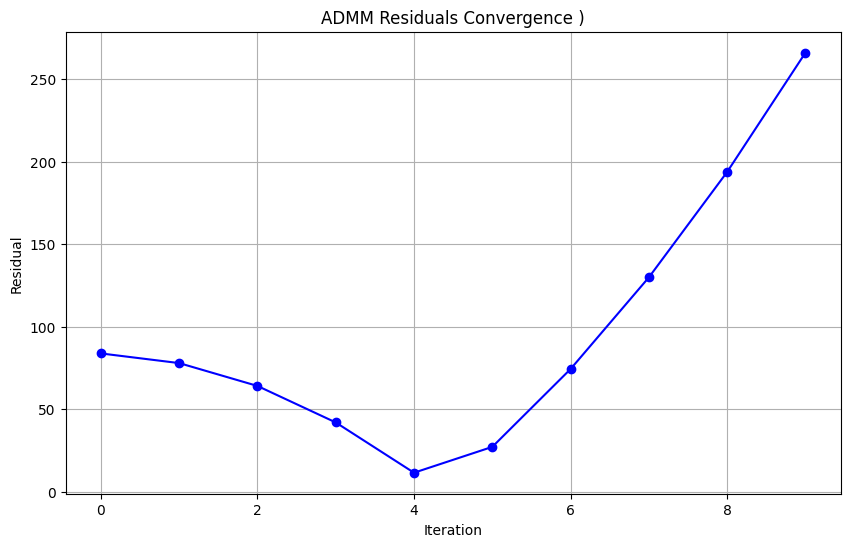

In [156]:
%matplotlib inline

visualize_residuals(prime_residuals_np)
visualize_residuals(fixed_residuals_np)
visualize_residuals(qp_cost_residuals_np)